# flyswot-gym 🦾

This notebook moves through the steps involved in training/updating a flyswot model. 

> This notebook assumes you have already updated the flysheet `dataset` (see the [flyswot-gym](https://github.com/davanstrien/flyswot-gym) repository for guidance on doing this.). 

The notebook goes through the following steps:
- downloading the training data
- preparing the dataset for training the model
- training the model 
- evaluating the model in various ways
- making a decision about whether to save the model 
- uploading the model to the 🤗 hub

**Note: this notebook is a WIP, things might change or not work properly**

In [ ]:
#@title Setup git and git-lfs
!apt install git-lfs && git init && git lfs install 
!git config --global credential.helper store

In [ ]:
#@title Install flyswot-gym
!pip -q install git+https://github.com/davanstrien/flyswot-gym.git

In [ ]:
from huggingface_hub import notebook_login
from huggingface_hub import hf_api
import torch

### Check for we have a GPU available

Google Colab gives us the option of running our code on a GPU. This is important for speeding up our training process. If the below cell fails check you have a GPU enabled. Sometimes you may have to wait a little while for Colab to have GPUs available. 


In [ ]:
assert torch.cuda.is_available()

## Define some training options

We define some different training options. The first `model_checkpoint` refers to the model we *start* our training from. This is setup to use an existing flyswot model by default. If you have made massive changes to the data, or are training on a new task you may want to change this model to another model. Any `image-classification` [model](https://huggingface.co/models?pipeline_tag=image-classification) *should* work. A safe bet is to start with `facebook/convnext-tiny-224`. To use any of these models pass in the Hub id. You can get this from the top of a model page on the hub by clicking on the double square icon

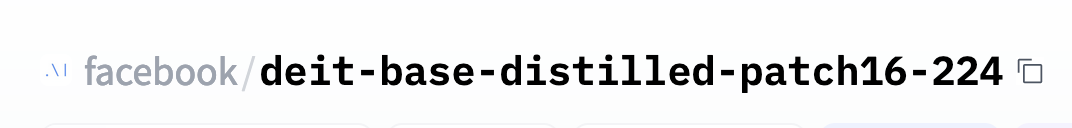

The other options are `training_dataset` this should point to a dataset you've uploaded using `hugit`. 

The number of epochs defines how long you will train your model for. If you are fine tuning an existing flyswot model you won't need to change this much but if you are training something new you will want to increase this value. 

In [ ]:
#@title Define training options
model_checkpoint = 'flyswot/convnext-tiny-224_flyswot' #@param ["flyswot/convnext-tiny-224_flyswot", "davanstrien/deit_flyswot"] {allow-input: true}
training_dataset = "davanstrien/hugit_hmd_flysheet" #@param ["flyswot/flysheet_data"] {allow-input: true}
number_of_epochs = 10 #@param {type:"slider", min:10, max:100, step:1}

## Tips

This notebook attempts to make the process of training/updating a model easier. This is partially done by creating some functions that do a bunch of different steps for you. In this notebook we often just call these functions. This means we see a couple of lines of code instead of a whole bunch of code. However, nothing is supposed to be hidden or magical because of this. If you want to know what a particular function is doing you can use a handy feature inside notebook to see what some code does. 
Placing `??` will show the source code for a function, for example, we can take a look at what `prep_data` is doing:

In [ ]:
from flyswot_gym.core import prep_data

In [ ]:
??prep_data

This means firstly that you can see more clearly what is happening but also if you feel like it's doing the wrong thing you can copy the code an update how that step of the notebook happens. 

# Login to the 🤗 hub 

Since we're using private datasets and we want to have the option of pushing our models to the 🤗 hub we ned to ensure we are logged in.

In [ ]:
notebook_login()

In [ ]:
api = hf_api.HfApi()
assert api._validate_or_retrieve_token()[0], "not logged in! Please try cell above again"

## Setup training data

This part of the notebook setups the training data for our model. The way in which the data is processed changes depending on our model which is why we need to pass in `model_checkpoint`. 

In [ ]:
from flyswot_gym.core import prep_data

In [ ]:
flyswot_data = prep_data(training_dataset, model_checkpoint=model_checkpoint)

In [ ]:
assert flyswot_data, "make sure you have loaded data sucessfully"

## Model training 
We now have our data ready, next we train a model. By default this will use the paramters we chose earlier but we can switch this around if needed. The `hub_model_id` variable defines what name our model will be saved as on the Hugging Face hub. This defaults to "flyswot". 

In [ ]:
from flyswot_gym import core

In [ ]:
trainer = core.train_model(flyswot_data,
                           model_checkpoint, 
                           num_epochs=num_epochs)

# Inspecting model results

This section is a WIP!

We have a model. No we want to know if it's any good. There are various ways in which we can explore this. First we can use the `trainer.predict` method to run our model against some test data.

In [ ]:
outputs = trainer.predict(flyswot_data.test_ds)

This output variable includes metrics for how our model performs on our test data.

In [ ]:
outputs.metrics

In [ ]:
import pandas as pd

In [ ]:
pd.DataFrame.from_dict(outputs.metrics,orient='index',columns=['score'])

In [ ]:
from sklearn.metrics import classification_report
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
print(classification_report(y_true, y_pred, target_names=flyswot_data.train_ds.features['label'].names))

In [ ]:
from flyswot_gym.core import plot_confusion_matrix

In [ ]:
plot_confusion_matrix(outputs,trainer=trainer)

In [ ]:
from flyswot_gym.core import create_test_results_df

In [ ]:
report_df = create_test_results_df(outputs,trainer, important_label='FLYSHEET', print_results=True,return_df=True)

In [ ]:
mistakes_df = report_df[report_df.y_true != report_df.y_pred]

In [ ]:
mistakes_df['y_prob'].max()

In [ ]:
from flyswot_gym.core import create_mistakes_image_navigator

In [ ]:
create_mistakes_image_navigator(report_df, flyswot_data, trainer)

## Push model to the hub? 

Once we have explored some of the model behaviour above we *should* have a better sense of whether it's a good model for our particular use case. In particular, we may explore how the model performs on one particular label.

In [ ]:
trainer.push_to_hub("finshed training")

## TODOs
- generate a model card automagically based on some of the metric results already included 

